In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

In [3]:
!cd ~/Documents/QCB455/finalProject

In [4]:
protein_data = pd.read_csv("protein_data_r.csv", index_col=0)
lipmet_data = pd.read_csv("lipmet_data_r.csv", index_col=0)
transcript_data = pd.read_csv("transcript_data_r.csv", index_col=0)

In [5]:
all_data = pd.concat([protein_data, lipmet_data, transcript_data], axis=1)
remove_subj = list(np.arange(104, 130)) + [54, 81, 88]
all_data = all_data.drop(labels=remove_subj)

In [6]:
all_data

,7593,7594,7595,7596,7597,7598,7599,7600,7601,7602,...,27790,27791,27792,27793,27794,27795,27796,27797,27798,27799
1,37.995543,22.751400,22.122531,27.176361,28.294477,22.830609,24.783368,23.926601,23.490571,25.490816,...,6.9,6.4,6.0,6.9,9.6,1.9,9.8,13.3,11.5,9.0
2,37.353091,21.477142,21.106922,29.419228,29.048510,26.660849,27.573331,24.671039,22.343591,27.166913,...,7.4,8.1,5.5,6.5,9.7,3.1,9.9,13.5,11.3,8.5
3,37.527875,20.647824,19.148225,27.174171,28.953215,20.212142,25.619161,24.528623,20.714471,25.589237,...,6.5,6.7,4.4,5.3,10.4,4.5,9.3,14.2,11.8,7.8
4,37.673128,21.828886,23.396629,28.879702,29.527460,26.439300,23.893562,25.875326,24.170967,25.280226,...,7.2,6.9,6.4,7.2,9.5,3.6,9.6,12.3,11.0,9.0
5,37.983542,18.769891,18.695882,27.262485,28.605867,22.957979,18.440251,20.888495,17.354782,25.654472,...,6.8,7.3,5.0,6.1,9.6,2.8,10.1,13.6,11.1,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,37.687017,19.460886,22.844985,29.417680,30.854747,21.117267,25.202957,26.348830,25.365263,24.867641,...,5.4,6.8,4.2,5.0,10.2,3.8,9.4,15.5,10.5,6.9
100,37.787556,20.058769,22.505137,26.969061,28.103146,23.802328,26.583481,25.303093,20.852103,25.527788,...,6.3,7.3,5.0,6.4,9.8,3.5,9.2,14.3,10.0,8.0
101,37.068980,23.029634,18.088656,32.415410,28.430139,28.490448,26.307425,26.740082,23.796498,26.716858,...,7.0,7.0,5.4,7.6,9.6,3.9,8.7,13.3,10.6,8.6
102,38.004675,17.275059,20.681851,26.636994,28.346803,26.581328,26.662073,25.585918,24.429053,26.073349,...,7.2,6.3,5.8,6.5,9.7,3.5,9.9,14.7,11.5,8.7


In [7]:
names = pd.read_csv("names_r.csv", index_col=0)
names

,biomolecule_id,standardized_name,omics_id
1,1,unknown RT 4.081766,3
2,2,unknown RT 4.148561,3
3,3,unknown RT 5.261918,3
4,4,unknown RT 5.349937,3
5,5,unknown RT 5.462593,3
...,...,...,...
27739,27795,ZYG11A,5
27740,27796,ZYG11B,5
27741,27797,ZYX,5
27742,27798,ZZEF1,5


In [8]:
names = names[~names['standardized_name'].str.contains('unknown', case=False)]

In [9]:
keep_cols = [str(x) for x in names['biomolecule_id'].tolist() if str(x) in list(all_data.columns)]

In [10]:
all_data = all_data[keep_cols]
all_data

,6,7,10,11,12,14,15,17,18,19,...,27790,27791,27792,27793,27794,27795,27796,27797,27798,27799
1,22.525987,10.453876,15.750871,16.262668,21.240711,12.736195,12.642085,15.740278,18.227404,22.398808,...,6.9,6.4,6.0,6.9,9.6,1.9,9.8,13.3,11.5,9.0
2,22.879847,12.930581,13.955800,12.969590,22.197342,13.564544,13.646637,17.004738,18.791764,20.612565,...,7.4,8.1,5.5,6.5,9.7,3.1,9.9,13.5,11.3,8.5
3,21.792056,12.698673,13.749587,14.456114,21.517347,12.477001,12.322656,13.143876,18.966138,22.830193,...,6.5,6.7,4.4,5.3,10.4,4.5,9.3,14.2,11.8,7.8
4,22.743837,13.183789,13.297381,13.145462,22.669942,12.414683,13.087547,16.610286,18.356654,23.611873,...,7.2,6.9,6.4,7.2,9.5,3.6,9.6,12.3,11.0,9.0
5,23.304373,12.809623,16.206185,16.531770,21.529698,11.763487,13.084803,16.971627,19.203116,20.414880,...,6.8,7.3,5.0,6.1,9.6,2.8,10.1,13.6,11.1,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,22.397412,12.956896,15.352831,15.540791,22.263340,12.582480,13.139734,17.383045,18.686790,23.524348,...,5.4,6.8,4.2,5.0,10.2,3.8,9.4,15.5,10.5,6.9
100,22.129562,13.516431,15.764481,16.042993,21.547324,11.995089,14.120953,16.780566,17.851581,13.442365,...,6.3,7.3,5.0,6.4,9.8,3.5,9.2,14.3,10.0,8.0
101,21.942203,13.364934,13.519000,13.948300,21.719975,12.589394,12.794340,12.924251,14.434120,12.964010,...,7.0,7.0,5.4,7.6,9.6,3.9,8.7,13.3,10.6,8.6
102,21.875789,12.155274,13.555614,14.791523,23.860713,13.172316,13.045859,13.794031,18.049573,24.356811,...,7.2,6.3,5.8,6.5,9.7,3.5,9.9,14.7,11.5,8.7


In [11]:
patient_data = pd.read_csv("patient_data_r.csv", index_col=0)
patient_data = patient_data.drop(labels=remove_subj)
patient_data

,sample_id,cov_status,hfd,sofa,charlson
1,1,1,0,8,0
2,2,1,39,0,2
3,3,1,18,0,2
4,4,1,39,0,1
5,5,1,27,7,1
...,...,...,...,...,...
99,99,1,0,4,5
100,100,1,35,0,6
101,101,1,37,6,3
102,102,1,0,0,7


In [12]:
hfds = patient_data['hfd']
median = np.median(hfds)
classes = ["severe" if hfd < median else "less_severe" for hfd in hfds]
all_data['class'] = classes
all_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,6,7,10,11,12,14,15,17,18,19,...,27791,27792,27793,27794,27795,27796,27797,27798,27799,class
1,22.525987,10.453876,15.750871,16.262668,21.240711,12.736195,12.642085,15.740278,18.227404,22.398808,...,6.4,6.0,6.9,9.6,1.9,9.8,13.3,11.5,9.0,severe
2,22.879847,12.930581,13.955800,12.969590,22.197342,13.564544,13.646637,17.004738,18.791764,20.612565,...,8.1,5.5,6.5,9.7,3.1,9.9,13.5,11.3,8.5,less_severe
3,21.792056,12.698673,13.749587,14.456114,21.517347,12.477001,12.322656,13.143876,18.966138,22.830193,...,6.7,4.4,5.3,10.4,4.5,9.3,14.2,11.8,7.8,severe
4,22.743837,13.183789,13.297381,13.145462,22.669942,12.414683,13.087547,16.610286,18.356654,23.611873,...,6.9,6.4,7.2,9.5,3.6,9.6,12.3,11.0,9.0,less_severe
5,23.304373,12.809623,16.206185,16.531770,21.529698,11.763487,13.084803,16.971627,19.203116,20.414880,...,7.3,5.0,6.1,9.6,2.8,10.1,13.6,11.1,8.6,less_severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,22.397412,12.956896,15.352831,15.540791,22.263340,12.582480,13.139734,17.383045,18.686790,23.524348,...,6.8,4.2,5.0,10.2,3.8,9.4,15.5,10.5,6.9,severe
100,22.129562,13.516431,15.764481,16.042993,21.547324,11.995089,14.120953,16.780566,17.851581,13.442365,...,7.3,5.0,6.4,9.8,3.5,9.2,14.3,10.0,8.0,less_severe
101,21.942203,13.364934,13.519000,13.948300,21.719975,12.589394,12.794340,12.924251,14.434120,12.964010,...,7.0,5.4,7.6,9.6,3.9,8.7,13.3,10.6,8.6,less_severe
102,21.875789,12.155274,13.555614,14.791523,23.860713,13.172316,13.045859,13.794031,18.049573,24.356811,...,6.3,5.8,6.5,9.7,3.5,9.9,14.7,11.5,8.7,severe


In [13]:
# train test split
def split(data):
    train_idx = list(pd.read_csv("train.csv")['train'])
    test_idx = []
    for i in list(patient_data['sample_id']):
        if i not in train_idx:
            test_idx.append(i)

    train = data.loc[train_idx]
    test = data.loc[test_idx]
    return train, test

In [14]:
train, test = split(all_data)

In [12]:
#train, test = train_test_split(all_data, test_size=0.2, random_state=15)
kf = KFold(n_splits=5, random_state=15)

In [149]:
def parameter_search():
    n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depths = [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None]
    min_samples_splits = [2, 5, 10]
    min_samples_leafs = [1, 2, 4]
    bootstraps = [True, False]
    
    
    best_score = -1
    best_n_est = -1
    best_max_feature = -1
    best_max_depth = -1
    best_min_samples_split = -1
    best_min_samples_leaf = -1
    best_bootstrap = -1
    
    num_iter = 1
    
    for n_estimator in n_estimators:
        for max_feature in max_features:
            for max_depth in max_depths:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leafs:
                        for bootstrap in bootstraps:
                            scores = []
                            folds = kf.split(train)
                            for train_idx, test_idx in folds:
                                clf = ExtraTreesClassifier(bootstrap=bootstrap, max_depth=max_depth, 
                                                           max_features=max_feature, min_samples_leaf=min_samples_leaf, 
                                                           min_samples_split=min_samples_split, n_estimators=n_estimator)
                                clf = clf.fit(np.array(train.drop(columns=["class"]))[train_idx], np.array(train["class"])[train_idx])
                                scores.append(clf.score(np.array(train.drop(columns=["class"]))[test_idx], np.array(train["class"])[test_idx]))
                            if np.mean(scores) > best_score:
                                print(np.mean(scores))
                                best_score = np.mean(scores)
                                best_n_est = n_estimator
                                best_max_feature = max_feature
                                best_max_depth = max_depth
                                best_min_samples_split = min_samples_split
                                best_min_samples_leaf = min_samples_leaf
                                best_bootstrap = bootstrap
                            print(num_iter)
                            num_iter += 1
                                
    return best_score, best_n_est, best_max_feature, best_max_depth, best_min_samples_split, best_min_samples_leaf, best_bootstrap

In [ ]:
best_score, best_n_est, best_max_feature, best_max_depth, best_min_samples_split,\
    best_min_samples_leaf, best_bootstrap = parameter_search()

In [ ]:
print("Best score:", best_score)
print("Best n_estimators:", best_n_est)
print("Best max features:", best_max_feature)
print("Best max depth:", best_max_depth)
print("Best min samples split:", best_min_samples_split)
print("Best min samples leaf:", best_min_samples_leaf)
print("Best bootstrap:", best_bootstrap)

In [15]:
clf_multi = ExtraTreesClassifier(random_state=15, bootstrap= True, max_depth= None, max_features = 'log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)
clf_multi = clf_multi.fit(train.drop(columns=["class"]), train["class"])

In [16]:
score = clf_multi.score(test.drop(columns=["class"]), test["class"])
score

0.75

In [107]:
clf_multi.classes_

array(['less_severe', 'severe'], dtype=object)

In [108]:
prob_multi = clf_multi.predict_proba(test.drop(columns=["class"]))[:,1]
roc_multi = roc_curve(test["class"], prob_multi, pos_label="severe")
auroc_multi = roc_auc_score(test["class"], prob_multi)
auroc_multi

0.9560439560439561

In [109]:
charlson_data = pd.concat([patient_data['charlson'], all_data['class']], axis=1)
train_charlson, test_charlson = split(charlson_data)
clf = ExtraTreesClassifier(random_state=15, bootstrap= False, max_depth= 10, max_features = 'log2', min_samples_leaf= 2, min_samples_split= 10, n_estimators= 100)
clf = clf.fit(train_charlson.drop(columns=["class"]), train_charlson["class"])

In [110]:
clf.score(test_charlson.drop(columns=["class"]), test_charlson["class"])

0.55

In [111]:
prob_charl = clf.predict_proba(test_charlson.drop(columns=["class"]))[:,1]
roc_charl = roc_curve(test_charlson["class"], prob_charl, pos_label="severe")
auroc_charl = roc_auc_score(test_charlson["class"], prob_charl)
auroc_charl

0.543956043956044

In [112]:
comb_data = pd.concat([patient_data['charlson'], all_data], axis=1)
train_comb, test_comb = split(comb_data)
clf = ExtraTreesClassifier(random_state=15, bootstrap= False, max_depth= 10, max_features = 'log2', min_samples_leaf= 2, min_samples_split= 10, n_estimators= 100)
clf = clf.fit(train_comb.drop(columns=["class"]), train_comb["class"])

In [113]:
clf.score(test_comb.drop(columns=["class"]), test_comb["class"])

0.75

In [114]:
prob_comb = clf.predict_proba(test_comb.drop(columns=["class"]))[:,1]
roc_comb = roc_curve(test_comb["class"], prob_comb, pos_label="severe")
auroc_comb = roc_auc_score(test_comb["class"], prob_comb)
auroc_comb

1.0

Text(0, 0.5, 'True Positive Rate')

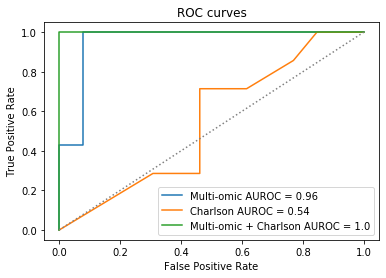

In [116]:
plt.plot(roc_multi[0], roc_multi[1], label="Multi-omic AUROC = 0.96") #0.956
plt.plot(roc_charl[0], roc_charl[1], label="Charlson AUROC = 0.54")
plt.plot(roc_comb[0], roc_comb[1], label="Multi-omic + Charlson AUROC = 1.0")
plt.plot([0,1], [0,1], linestyle=":", color="gray")
plt.legend()
plt.title("ROC curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Text(32, 0, 'accuracy = 0.75\nrecall = 1.0\nprecision = 0.58\nF1 = 0.737\nave. prec. = 0.91\nROC AUC = 0.96')

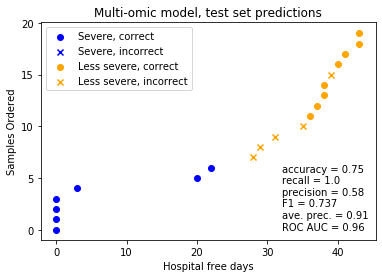

In [124]:
preds = list(clf_multi.predict(test.drop(columns=["class"])))
probs = (clf_multi.predict_proba(test.drop(columns=["class"])))[:,1]
targets = list(test['class'])
_, hfds = split(patient_data['hfd'])
hfds = list(hfds)
#hfd_order = np.argsort(hfd)
#hfd_ordered = np.sort(hfd)

severe_true_x = []
severe_true_y = []
less_severe_true_x = []
less_severe_true_y = []
severe_false_x = []
severe_false_y = []
less_severe_false_x = []
less_severe_false_y = []

for i in range(len(hfds)):
    min_hfd = np.min(hfds)
    argmin_hfd = np.argmin(hfds)
    
    # class labels are switched
    if targets[argmin_hfd] == 'severe' and targets[argmin_hfd]==preds[argmin_hfd]:
        severe_true_x.append(min_hfd)
        severe_true_y.append(i)
    elif targets[argmin_hfd] == 'severe' and targets[argmin_hfd]!=preds[argmin_hfd]:
        severe_false_x.append(min_hfd)
        severe_false_y.append(i)
    elif targets[argmin_hfd] == 'less_severe' and targets[argmin_hfd]==preds[argmin_hfd]:
        less_severe_true_x.append(min_hfd)
        less_severe_true_y.append(i)
    else:
        less_severe_false_x.append(min_hfd)
        less_severe_false_y.append(i)
        
    hfds[argmin_hfd] = 50
        
plt.scatter(severe_true_x, severe_true_y, marker="o", color="blue", label="Severe, correct")
plt.scatter(severe_false_x, severe_false_y, marker="x", color="blue", label="Severe, incorrect")
plt.scatter(less_severe_true_x, less_severe_true_y, marker="o", color="orange", label="Less severe, correct")
plt.scatter(less_severe_false_x, less_severe_false_y, marker="x", color="orange", label="Less severe, incorrect")
plt.title("Multi-omic model, test set predictions")
plt.xlabel("Hospital free days")
plt.ylabel("Samples Ordered")
plt.yticks(np.arange(0,21,5))
plt.legend()

info = "accuracy = 0.75"
info += "\nrecall = 1.0"
info += "\nprecision = 0.58"
info += "\nF1 = 0.737"
info += "\nave. prec. = 0.91"
info += "\nROC AUC = 0.96"

plt.annotate(info, xy=(32,0))

In [118]:
count_correct = 0
for i in range(len(preds)):
    if preds[i] == targets[i]:
        count_correct += 1
accuracy = count_correct/len(preds)
accuracy

0.75

In [119]:
recall = recall_score(targets, preds, pos_label="severe")
recall

1.0

In [120]:
precision = precision_score(targets, preds, pos_label="severe")
precision

0.5833333333333334

In [121]:
f1 = f1_score(targets, preds, pos_label="severe")
f1

0.7368421052631579

In [122]:
ave_prec = average_precision_score(targets, probs, pos_label="severe")
ave_prec

0.9093537414965986

In [123]:
auroc_multi

0.9560439560439561

In [41]:
importances = clf_multi.feature_importances_
features = np.argsort(clf_multi.feature_importances_)
top_features = []
top_imp = []
for i in features[-5:]:
    top_features.append(all_data.columns[i])
    top_imp.append(importances[i])

In [42]:
features[-5:]

array([ 4747, 17789, 20590,  1948,  1111])

In [43]:
top_features

['11462', '24504', '27305', '8663', '7826']

In [44]:
top_imp

[0.0026473469719446286,
 0.00298138873229437,
 0.00315221474339829,
 0.0036288268906530326,
 0.004116250837844542]

In [52]:
mols = ['CHURC1-FNTB', 'STK39', 'ZNF26', 'ADGRB2', 'APOM']

Text(0.5, 0, 'Feature importance')

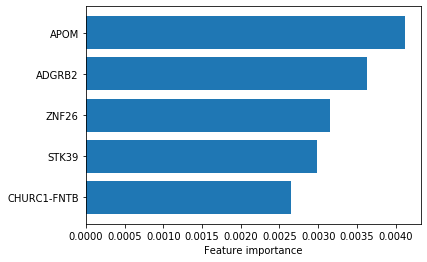

In [54]:
fig, ax = plt.subplots()
y_pos = np.arange(5)
ax.barh(y_pos, top_imp)
ax.set_yticks(y_pos)
ax.set_yticklabels(mols)
ax.set_xlabel('Feature importance')